In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler , LabelEncoder
import pandas 
from sklearn.model_selection import train_test_split
from torchmetrics.functional import f1_score, mean_absolute_percentage_error, r2_score
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random

# 데이터 핸들링 부분, ( 이 부분은 안써요 )

In [64]:

# 데이터 로드
df = pandas.read_csv("./lending_club_2020_train.csv", low_memory=False)
df['target'] = df['total_rec_prncp']/df['funded_amnt']


In [65]:

# 'target' 열을 레이블로 사용하고 나머지 열은 특성으로 사용
y = df['target'].values  # 'target' 열을 레이블로 사용
x = df.drop(columns=['target']).select_dtypes(include=[float, int])  # 'target' 열을 제외한 숫자형 열을 특성으로 사용

# NaN 값이 있는 모든 행을 삭제합니다.
x['target'] = y  # y를 다시 x에 추가하여 동시 정렬을 보장합니다.
x_clean = x.dropna()  # NaN 값이 있는 행 삭제

# NaN을 제거한 후 x와 y를 분리
y_clean = x_clean['target'].values
x_clean = x_clean.drop(columns=['target']).values


# 데이터 스플릿 (train 50%, validation 30%, test 20%)
x_train, x_temp, y_train, y_temp = train_test_split(x_clean, y_clean, test_size=0.5, random_state=42)  # 50% train, 50% temp
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.4, random_state=42)  # 30% valid, 20% test

# 데이터 스케일링
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)


# 텐서로 변환

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # 크기를 (batch_size, 1)로 맞추기 위해 unsqueeze 추가
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)  # 크기를 (batch_size, 1)로 맞추기 위해 unsqueeze 추가
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # 크기를 (batch_size, 1)로 맞추기 위해 unsqueeze 추가


# 여기서부터 모델 


In [72]:


# 데이터셋 및 데이터로더 생성 (미니 배치로 학습시키기 위해)
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_valid, y_valid)

# DataLoader 생성 (shuffle은 학습 데이터에만 적용)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [67]:
# Device 설정 (CUDA GPU 또는 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [68]:
# 모델 정의 ## # 회귀 
class LinearNN(nn.Module):
    def __init__(self, input_dim, units_per_layer, dropout_rate):
        super(LinearNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, units_per_layer)
        self.fc2 = nn.Linear(units_per_layer, units_per_layer)
        self.fc3 = nn.Linear(units_per_layer, 1)  # 출력 뉴런은 1개 (회귀 문제)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # 활성화 함수를 사용하지 않음 (회귀 문제)
        return x

# 그리드 서치 / 회귀 

In [69]:
# 하이퍼파라미터 설정 리스트
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
units_per_layers = [32, 64, 128]
dropout_rates = [0.3, 0.5]

# 최적의 결과를 추적하기 위한 변수 초기화
best_val_loss = float('inf')
best_hyperparams = None

In [73]:


# 하이퍼파라미터 튜닝을 위한 반복 구조
for lr in learning_rates:
    for batch_size in batch_sizes:
        for units_per_layer in units_per_layers:
            for dropout_rate in dropout_rates:
                print(f'Training with lr={lr}, batch_size={batch_size}, units_per_layer={units_per_layer}, dropout_rate={dropout_rate}')
                
                # 데이터 로더 생성 (batch_size 변경)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                # 모델 초기화
                input_dim = x_train.shape[1]
                model = LinearNN(input_dim, units_per_layer, dropout_rate).to(device)
                
                # 옵티마이저 및 손실 함수 설정
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.L1Loss() # 회귀 문제에 적합한 손실 함수 사용

                # Early Stopping 초기화
                patience = 10
                early_stopping_counter = 0
                current_best_val_loss = float('inf')
                
                # 학습 함수 정의
                def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience, device):
                    model.train()  # 학습 모드로 설정
                    for epoch in range(epochs):
                        epoch_loss = 0.0
                        for inputs, labels in train_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            optimizer.zero_grad()  # 그래디언트 초기화
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()  # 역전파
                            optimizer.step()  # 파라미터 업데이트
                            epoch_loss += loss.item()
                        
                        # 검증 손실 계산
                        val_loss = validate_model(model, val_loader, criterion, device)
                        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')
                        
                        # Early Stopping 확인
                        global early_stopping_counter, current_best_val_loss
                        if val_loss < current_best_val_loss:
                            current_best_val_loss = val_loss
                            early_stopping_counter = 0  # 카운터 초기화
                        else:
                            early_stopping_counter += 1
                        
                        if early_stopping_counter >= patience:
                            print("Early stopping!")
                            break

                # 검증 함수 정의
                def validate_model(model, val_loader, criterion, device):
                    model.eval()  # 평가 모드로 설정
                    val_loss = 0.0
                    with torch.no_grad():
                        for inputs, labels in val_loader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            val_loss += loss.item()
                    return val_loss / len(val_loader)

                # 모델 학습
                train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=patience, device=device)

                # 최적의 하이퍼파라미터 업데이트
                if current_best_val_loss < best_val_loss:
                    best_val_loss = current_best_val_loss
                    best_hyperparams = (lr, batch_size, units_per_layer, dropout_rate)
                    print(f'New best validation loss: {best_val_loss:.4f}')


print(f'Best hyperparameters: lr={best_hyperparams[0]}, batch_size={best_hyperparams[1]}, units_per_layer={best_hyperparams[2]}, dropout_rate={best_hyperparams[3]}')


Training with lr=0.001, batch_size=32, units_per_layer=32, dropout_rate=0.3
Epoch 1/100, Loss: 0.2995, Val Loss: 0.2641
Epoch 2/100, Loss: 0.2853, Val Loss: 0.2340
Epoch 3/100, Loss: 0.3071, Val Loss: 0.2085
Epoch 4/100, Loss: 0.2234, Val Loss: 0.1855
Epoch 5/100, Loss: 0.1967, Val Loss: 0.1643
Epoch 6/100, Loss: 0.1702, Val Loss: 0.1445
Epoch 7/100, Loss: 0.1718, Val Loss: 0.1370
Epoch 8/100, Loss: 0.1495, Val Loss: 0.1404
Epoch 9/100, Loss: 0.1506, Val Loss: 0.1425
Epoch 10/100, Loss: 0.1272, Val Loss: 0.1440
Epoch 11/100, Loss: 0.1111, Val Loss: 0.1455
Epoch 12/100, Loss: 0.0950, Val Loss: 0.1495
Epoch 13/100, Loss: 0.0951, Val Loss: 0.1514
Epoch 14/100, Loss: 0.0860, Val Loss: 0.1510
Epoch 15/100, Loss: 0.0674, Val Loss: 0.1488
Epoch 16/100, Loss: 0.0594, Val Loss: 0.1452
Epoch 17/100, Loss: 0.0602, Val Loss: 0.1418
Early stopping!
Training with lr=0.001, batch_size=32, units_per_layer=32, dropout_rate=0.5
Epoch 1/100, Loss: 0.2624, Val Loss: 0.1977
Epoch 2/100, Loss: 0.1901, Val L

Epoch 1/100, Loss: 0.2476, Val Loss: 0.1989
Early stopping!
MSE: 0.0824
MAE: 0.2236
RMSE: 0.2870
MAPE: 2.1363
R-squared (R²): 0.2044
Predictions:  [0.42258024 0.40179813 0.22891968 0.50939775 0.5632059  0.47730932
 0.44034815 0.610952   0.56968766 0.26392597]
Actuals:  [1.         0.02058912 0.08884688 0.598165   0.5914565  0.72297
 0.23890625 0.5970628  0.08134608 0.15385374]


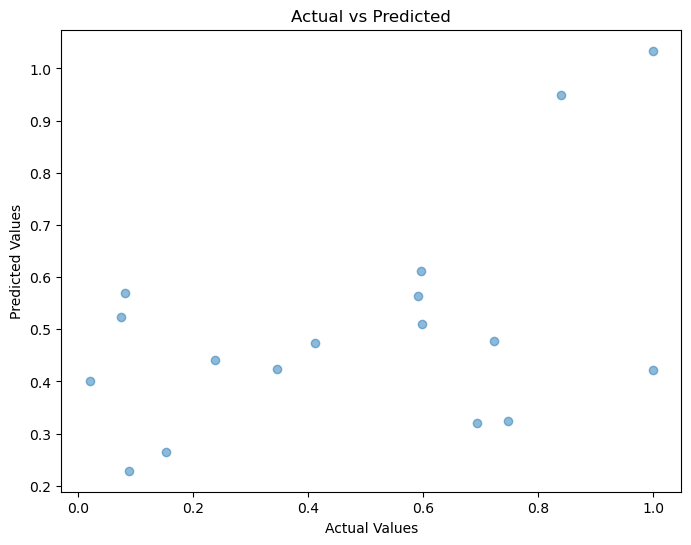

In [78]:
# 최적의 하이퍼파라미터로 모델 평가
input_dim = x_train.shape[1]
best_model = LinearNN(input_dim, best_hyperparams[2], best_hyperparams[3]).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams[0])
train_loader = DataLoader(train_dataset, batch_size=best_hyperparams[1], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_hyperparams[1], shuffle=False)

# 최적의 모델 학습
train_model(best_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=patience, device=device)

# 모델 평가

# 모델 평가 함수 정의 (회귀 지표 포함)
def evaluate_model_and_metrics(model, test_loader, device):
    model.eval()  # 평가 모드로 설정
    predictions = []
    actuals = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화 (평가 시에는 필요 없음)
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 예측값 계산
            outputs = model(inputs)
            
            # 예측값과 실제값을 리스트에 저장
            predictions.extend(outputs.cpu().numpy())  # GPU에서 CPU로 이동 후 numpy로 변환
            actuals.extend(labels.cpu().numpy())  # GPU에서 CPU로 이동 후 numpy로 변환
    
    # NumPy 배열로 변환
    predictions = np.array(predictions).flatten()  # 예측값을 1차원 배열로 변환
    actuals = np.array(actuals).flatten()  # 실제값을 1차원 배열로 변환
    
    # 회귀 성능 지표 계산
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    
    return predictions, actuals

# Test DataLoader 생성
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 평가 및 예측 결과 확인
predictions, actuals = evaluate_model_and_metrics(best_model, test_loader, device)

# 결과 출력
# 예측 결과 일부를 출력
print("Predictions: ", predictions[:10])
print("Actuals: ", actuals[:10])

# 예측 결과 시각화 (예: 실제값 vs 예측값)
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()